# 🍰 [Day 5](https://adventofcode.com/2021/day/5)

In [1]:
import bisect
from matplotlib import pyplot as plt

def parse_line(l):
    """Parse lines"""
    src, tgt = l.split(' -> ')
    x1, y1 = src.split(',')
    x2, y2 = tgt.split(',')
    return int(x1), int(y1), int(x2), int(y2)

def plot_winds(lines):
    """Plot winds map"""
    plt.figure(figsize=(12, 12))
    for l in lines:
        x1, y1, x2, y2 = parse_line(l)
        if x1 == x2:
            color = "orange"
        elif x1 > x2:
            color = "cornflowerblue"
        else:
            color = "hotpink"
        if y1 == y2:
            linestyle = "solid"
        elif y1 > y2:
            linestyle = "dashed"
        else:
            linestyle = "dotted"
            
        plt.plot([x1, x2], [y1, y2], color=color, linestyle=linestyle)
    plt.axis('off')
    plt.suptitle("Winds map", fontsize=16, y=0.89)
    plt.show()
    
    
def find_num_intersections(lines, only_hv=True):
    """A way too complex and prne-to-bugs intersection finding solution"""
    horizontal_lines = []
    vertical_lines = []
    # same as horizontal and vertical lines but considering a 90 degree rotation
    diagonal_lines_up = []
    diagonal_lines_down = []
    pts = []
    for l in lines:
        x1, y1, x2, y2 = parse_line(l)
        going_up = (x1 < x2 and y2 < y1) or (x1 > x2 and y2 > y1)
        x1, x2 = sorted([x1, x2])
        y1, y2 = sorted([y1, y2])
        
        # Skip diagonal lines
        if only_hv and x2 > x1 and y2 > y1:
            continue
        
        # intersections with horizontal lines
        for y, xa, xb in horizontal_lines:
            # skip non-intersecting segment
            if y < y1:
                continue
            if y > y2:
                break
            if x1 > xb or x2 < xa:
                continue
            # if current is also an horizontal line
            if y == y1 == y2:
                pts.extend((x, y) for x in range(max(x1, xa), min(x2, xb) + 1))
            # otherwise, find the unique interesection point
            else:
                x_int = x1 if (x1 == x2) else (x1 + y2 - y) if going_up else (x1 + y - y1)
                if xa <= x_int <= xb and x1 <= x_int <= x2:
                    pts.append((x_int, y))
                
        # intersections with vertical lines (same)
        for x, ya, yb in vertical_lines:
            if x < x1:
                continue
            if x > x2:
                break
            if y1 > yb or y2 < ya:
                continue
            if x == x1 == x2:
                pts.extend((x, y) for y in range(max(y1, ya), min(y2, yb) + 1))
            else:
                y_int = y1 if (y1 == y2) else (y2 - x + x1) if going_up else (y1 + x - x1)
                if ya <= y_int <= yb and y1 <= y_int <= y2:
                    pts.append((x, y_int))
                
        # intersections with diagonal lines up ((xa, yb) to (xb, ya))
        for xa, xb, ya, yb in diagonal_lines_up:
            # easy skip
            if (x1 > xb or x2 < xa) or (y1 > yb or y2 < ya):
                continue
            # horizontal lines
            if y1 == y2:
                x_int = xa + yb - y1
                if x1 <= x_int <= x2 and xa <= x_int <= xb:
                    pts.append((x_int, y1))
            # vertical lines
            elif x1 == x2:
                y_int = yb - x1 + xa
                if ya <= y_int <= yb and y1 <= y_int <= y2:
                    pts.append((x1, y_int))
            # other diagonals going up
            elif going_up:
                if (y2 - yb) == (xa - x1):
                    start = (xa, yb) if xa > x1 else (x1, y2)
                    end = (xb, ya) if xb < x2 else (x2, y1)
                    pts.extend((x, y) for x, y in zip(range(start[0], end[0] + 1),
                                                      range(start[1], end[1] - 1, -1)))
            # diagonals going down
            # xa + t = x1 + u
            # yb - t = y1 + u
            # u = xa - x1 + t
            # 2 * t = yb - y1 - xa + x1
            else:
                t = (yb - y1 - xa + x1)
                if t % 2 == 0:
                    t = int(t / 2)
                    u = xa - x1 + t
                    assert xa + t == x1 + u
                    assert yb - t == y1 + u
                    if (xa <= xa + t <= xb and x1 <= xa + t <= x2 and 
                        ya <= yb - t <= yb and y1 <= yb - t <= y2):
                        pts.append((xa + t, yb - t))
            
        # intersections with diagonal lines down ((xa, ya) to (xb, yb))
        for xa, xb, ya, yb in diagonal_lines_down:
            # easy skip
            if (x1 > xb or x2 < xa) or (y1 > yb or y2 < ya):
                continue
            # horizontal lines
            if y1 == y2:
                x_int = xa + y1 - ya
                if x1 <= x_int <= x2 and xa <= x_int <= xb:
                    pts.append((x_int, y1))
            # vertical lines
            elif x1 == x2:
                y_int = ya + x1 - xa
                if ya <= y_int <= yb and y1 <= y_int <= y2:
                    pts.append((x1, y_int))
            # other diagonals going down
            elif not going_up:
                if (ya - y1) == (xa - x1):
                    start = (xa, ya) if xa > x1 else (x1, y1)
                    end = (xb, yb) if xb < x2 else (x2, y2)
                    pts.extend((x, y) for x, y in zip(range(start[0], end[0] + 1),
                                                      range(start[1], end[1] + 1)))
            # diagonals going up
            # x1 + t = xa + u
            # y2 - t = ya + u
            # u = x1 - xa + t
            # 2 * t = y2 - ya - x1 + xa
            else:
                t = y2 - ya - x1 + xa
                if t % 2 == 0:
                    t = int(t / 2)
                    u = x1 - xa + t
                    assert x1 + t == xa + u
                    assert y2 - t == ya + u
                    if (xa <= x1 + t <= xb and x1 <= x1 + t <= x2 and 
                        ya <= y2 - t <= yb and y1 <= y2 - t <= y2):
                        pts.append((x1 + t, y2 - t))
            
        # Add current line to list
        if x1 == x2:
            bisect.insort_left(vertical_lines, (x1, y1, y2))
        elif y1 == y2:
            bisect.insort_left(horizontal_lines, (y1, x1, x2))
        elif going_up:
            diagonal_lines_up.append((x1, x2, y1, y2))
        else:
            diagonal_lines_down.append((x1, x2, y1, y2))
    return len(set(pts))


from collections import defaultdict
def dict_solution(lines):
    """A simple dictionary solution"""
    pts = defaultdict(lambda: 0)
    for l in lines:
        x1, y1, x2, y2 = parse_line(l)
        if x1 == x2:
            for y in range(min(y1, y2), max(y1, y2) + 1):
                pts[(x1, y)] += 1
        elif y1 == y2:
            for x in range(min(x1, x2), max(x1, x2) + 1):
                pts[(x, y1)] += 1
        else:
            going_up = (x1 < x2 and y2 < y1) or (x1 > x2 and y2 > y1)
            start = max(y1, y2) if going_up else min(y1, y2)
            inc = (-1) if going_up else +1
            for x in range(min(x1, x2), max(x1, x2) + 1):
                pts[(x, start)] += 1
                start += inc
    return sum(v > 1 for v in pts.values())

In [2]:
with open('inputs/day05.txt', 'r') as f:
    inputs = f.read().splitlines()
    
print("The horizontal and vertical winds have \033[92;1m{}\033[0m intersection points".format(
    find_num_intersections(inputs, only_hv=True)))
print("The set of all winds have \033[92;1m{}\033[0m intersection points".format(
    find_num_intersections(inputs, only_hv=False)))
print("The dictionary solution also finds \033[92;1m{}\033[0m intersection points".format(
    dict_solution(inputs)))

The horizontal and vertical winds have 7674 intersection points
The set of all winds have 20898 intersection points
The dictionary solution also finds 20898 intersection points


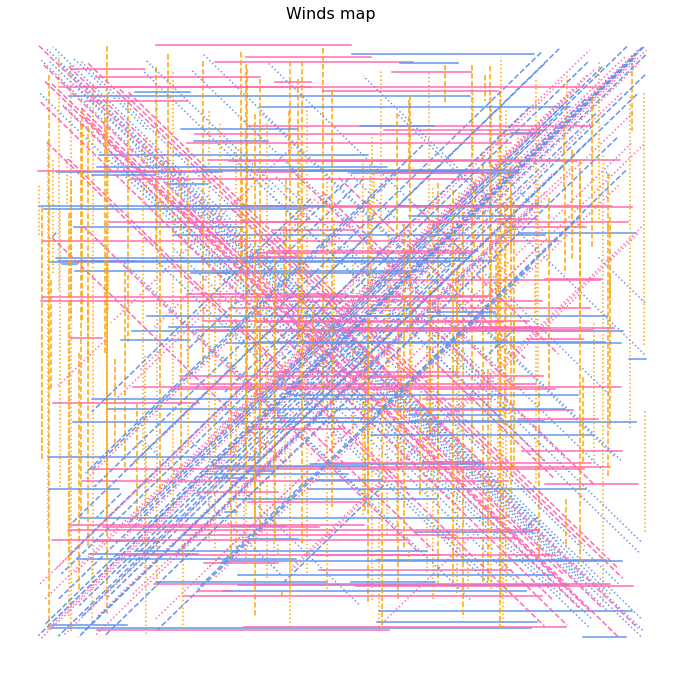

In [3]:
plot_winds(inputs)